In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import joblib
import numpy as np

In [2]:
# Haetaan esikäsitelty data
df = pd.read_csv("../data/processed_data.csv")

# Muutetaan state -> binary
df["state_binary"] = df["state"].apply(lambda x: 1 if x == "successful" else 0)


In [3]:
def add_creator_history_features(
    df: pd.DataFrame,
    creator_col: str = "creator_id",
    launch_col: str = "launched_date",
    state_col: str = "state",
    success_label: str = "successful",
) -> pd.DataFrame:
    """
    Lisää:
    - creator_prev_projects
    - creator_prev_projects_successful
    - creator_prev_projects_success_rate
    creator_id ja launched_date järjestyksen mukaan.
    """

    df = df.copy()

    # 1) Varmista datetime
    df["_launch_dt"] = pd.to_datetime(df[launch_col], errors="coerce")

    # 2) Järjestä creator + aika
    df_sorted = df.sort_values([creator_col, "_launch_dt"])

    # 3) Binaarinen onnistumismittari
    df_sorted["_is_success"] = (df_sorted[state_col] == success_label).astype(int)

    # 4) KU-MU-LAATIIVISET laskurit CREATOR-KOHTAISESTI
    df_sorted["creator_prev_projects_successful"] = (
        df_sorted.groupby(creator_col)["_is_success"].cumsum()
        - df_sorted["_is_success"]
    )

    df_sorted["creator_prev_projects"] = (
        df_sorted.groupby(creator_col).cumcount()
    )

    # 5) Success rate (0 jos ei projekteja)
    df_sorted["creator_prev_projects_success_rate"] = (
        df_sorted["creator_prev_projects_successful"]
        / df_sorted["creator_prev_projects"].replace(0, pd.NA)
    ).fillna(0.0)

    # 6) Siivoa
    df_sorted = df_sorted.drop(columns=["_launch_dt", "_is_success"])
    df_final = df_sorted.sort_index()

    return df_final

df = add_creator_history_features(
    df,
    creator_col="creator_id",
    launch_col="launched_date",
    state_col="state",
    success_label="successful"
)

df[[
    "creator_id",
    "launched_date",
    "state",
    "creator_prev_projects",
    "creator_prev_projects_successful",
    "creator_prev_projects_success_rate"
]].head()

C:\Users\nkyll\AppData\Local\Temp\ipykernel_11428\3175183292.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0.0)


,creator_id,launched_date,state,creator_prev_projects,creator_prev_projects_successful,creator_prev_projects_success_rate
0,74501917,2022-03-01,successful,1,1,1.0
1,597507018,2015-02-24,successful,1,1,1.0
2,237961243,2024-08-06,successful,11,11,1.0
3,203090294,2014-07-08,successful,1,0,0.0
4,1350948450,2020-03-31,successful,4,4,1.0


In [4]:
def add_project_duration(
    df: pd.DataFrame,
    launch_col: str = "launched_date",
    deadline_col: str = "deadline",
    new_col: str = "project_duration_days",
) -> pd.DataFrame:
    """
    Lisää DataFrameen sarakkeen, joka kertoo projektin keston päivinä.

    Parametrit
    ----------
    df : pd.DataFrame
        Syötedata, jossa on vähintään launch_col ja deadline_col.
    launch_col : str
        Sarake, jossa projektin aloituspäivä (esim. 'launched_date').
    deadline_col : str
        Sarake, jossa projektin deadline (esim. 'deadline').
    new_col : str
        Uuden kestosarakkeen nimi (oletus 'project_duration_days').

    Palauttaa
    ---------
    pd.DataFrame
        Kopio df:stä, jossa uusi sarake `new_col`.
    """

    df = df.copy()

    # Muutetaan päivämäärät datetime-muotoon (jos eivät jo ole)
    launch_dt = pd.to_datetime(df[launch_col], errors="coerce")
    deadline_dt = pd.to_datetime(df[deadline_col], errors="coerce")

    # Lasketaan erotus päivinä
    df[new_col] = (deadline_dt - launch_dt).dt.days

    return df

df = add_project_duration(
    df,
    launch_col="launched_date",
    deadline_col="deadline",
    new_col="project_duration_days",
)

print(df[["launched_date", "deadline", "project_duration_days", "creator_prev_projects"]].head())

  launched_date    deadline  project_duration_days  creator_prev_projects
0    2022-03-01  2022-03-31                     30                      1
1    2015-02-24  2015-03-28                     32                      1
2    2024-08-06  2024-08-30                     24                     11
3    2014-07-08  2014-08-30                     53                      1
4    2020-03-31  2020-05-01                     31                      4


In [19]:

def add_log_goal_feature(
    df: pd.DataFrame,
    goal_col: str = "usd_goal_fx",
    new_col: str = "usd_goal_fx_log",
) -> pd.DataFrame:
    """
    Lisää logaritmimuunnoksen goal-sarakkeesta.
    
    Käyttää log(goal + 1) -muunnosta, jotta goal=0 ei aiheuta ongelmia.
    (0 ei käytännössä esiinny Kickstarterissa, mutta +1 on täysin turvallinen.)
    """

    df = df.copy()

    # Varmistetaan, että sarake on numerinen
    df[goal_col] = pd.to_numeric(df[goal_col], errors="coerce")

    # Lisätään logaritmimuunnos
    df[new_col] = np.log(df[goal_col] + 1)

    return df

df = add_log_goal_feature(df)
print(df[["usd_goal_fx_log", "usd_goal_fx"]].head())

   usd_goal_fx_log  usd_goal_fx
0        13.815512    1000000.0
1        13.122365     500000.0
2        12.429220     250000.0
3        10.819798      50000.0
4        13.122365     500000.0


In [20]:
def reduce_subcategories(
    df: pd.DataFrame,
    main_col: str = "main_category",
    sub_col: str = "sub_category",
    min_n: int = 200,
    new_col: str = "sub_category_reduced",
) -> pd.DataFrame:
    """
    Yhdistää harvinaiset (main, sub) -kategoriat arvoon 'OTHER', mutta varmistaa,
    että jokaisella pääkategorialla (main_col) on vähintään yksi oma sub-kategoria.

    Logiikka:
    1. Lasketaan (main, sub) -pari kunkin frekvenssi (n).
    2. Valitaan kaikki parit, joilla n >= min_n.
    3. Jos jollain main-kategorialla ei ole yhtään >= min_n,
       mukaan otetaan sen yleisin sub-kategoria.
    4. Kaikki (main, sub) -parit, jotka eivät ole "sallittujen" joukossa,
       saavat arvon 'OTHER' sarakkeessa new_col.
    """

    df = df.copy()

    # 1) Laske (main, sub) frekvenssit
    counts = (
        df.groupby([main_col, sub_col])
        .size()
        .reset_index(name="n")
    )

    # 2) (main, sub) -parit, joilla vähintään min_n havaintoa
    frequent = counts[counts["n"] >= min_n].copy()

    # 3) Varmista, että jokaisella main-kategorialla on vähintään yksi sub
    for main in counts[main_col].unique():
        if main not in frequent[main_col].values:
            top_row = (
                counts[counts[main_col] == main]
                .sort_values("n", ascending=False)
                .iloc[0]
            )
            frequent = pd.concat([frequent, top_row.to_frame().T],
                                 ignore_index=True)

    # 4) Muodosta set sallituista (main, sub) -pareista
    allowed_pairs = set(zip(frequent[main_col], frequent[sub_col]))

    # 5) Luo uusi sarake: jos pari ei allowedissa → OTHER
    def _reduce_row(row):
        key = (row[main_col], row[sub_col])
        return row[sub_col] if key in allowed_pairs else "OTHER"

    df[new_col] = df.apply(_reduce_row, axis=1)

    return df

df = reduce_subcategories(
    df,
    main_col="category_parent_name",
    sub_col="category_name",
    min_n=200,
    new_col="category_name_reduced",   # tms.
)

KeyError: 'category_name'

In [7]:
# Jaetaan piirteet
numeric_features = ["usd_goal_fx_log", "creator_prev_projects", "project_duration_days", "creator_prev_projects_successful"]
date_features = ["launched_date", "deadline"]
categorical_features = ["country", "currency", "category_parent_name"]

In [8]:
# Jaetaan päivämäärät omiin sarakkeisiin vuoden, kuukauden ja päivän mukaan

for col in date_features:
    df[col] = pd.to_datetime(df[col])
    df[col + "_year"] = df[col].dt.year
    df[col + "_month"] = df[col].dt.month
    df[col + "_day"] = df[col].dt.day

categorical_features += ["launched_date_month", "deadline_month", "launched_date_year", "deadline_year"]

print(df[["launched_date_month", "deadline_month"]].head())

   launched_date_month  deadline_month
0                    3               3
1                    2               3
2                    8               8
3                    7               8
4                    3               5


In [9]:
# Piirteet
X = df[numeric_features + categorical_features]

y = df["state_binary"]

In [10]:
# OneHotEncoder kategorisille piirteille

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ],
    remainder="passthrough"
)

In [11]:
# Päätöspuu malli

clf = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=50,
    min_samples_leaf=10,
    max_features=None,
    criterion="entropy",
    class_weight=None,
    random_state=42,
)

In [12]:
# Pipeline
model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("classifier", clf)
])

In [13]:
# Train/Test jako

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [14]:
# Mallin koulutus

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [15]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.700991858876005

Classification report:
               precision    recall  f1-score   support

           0       0.70      0.78      0.74     65188
           1       0.70      0.60      0.65     54083

    accuracy                           0.70    119271
   macro avg       0.70      0.69      0.69    119271
weighted avg       0.70      0.70      0.70    119271


Confusion matrix:
 [[51054 14134]
 [21529 32554]]


In [14]:
print(clf.n_features_in_)
print(X_train.shape[1])


81
8


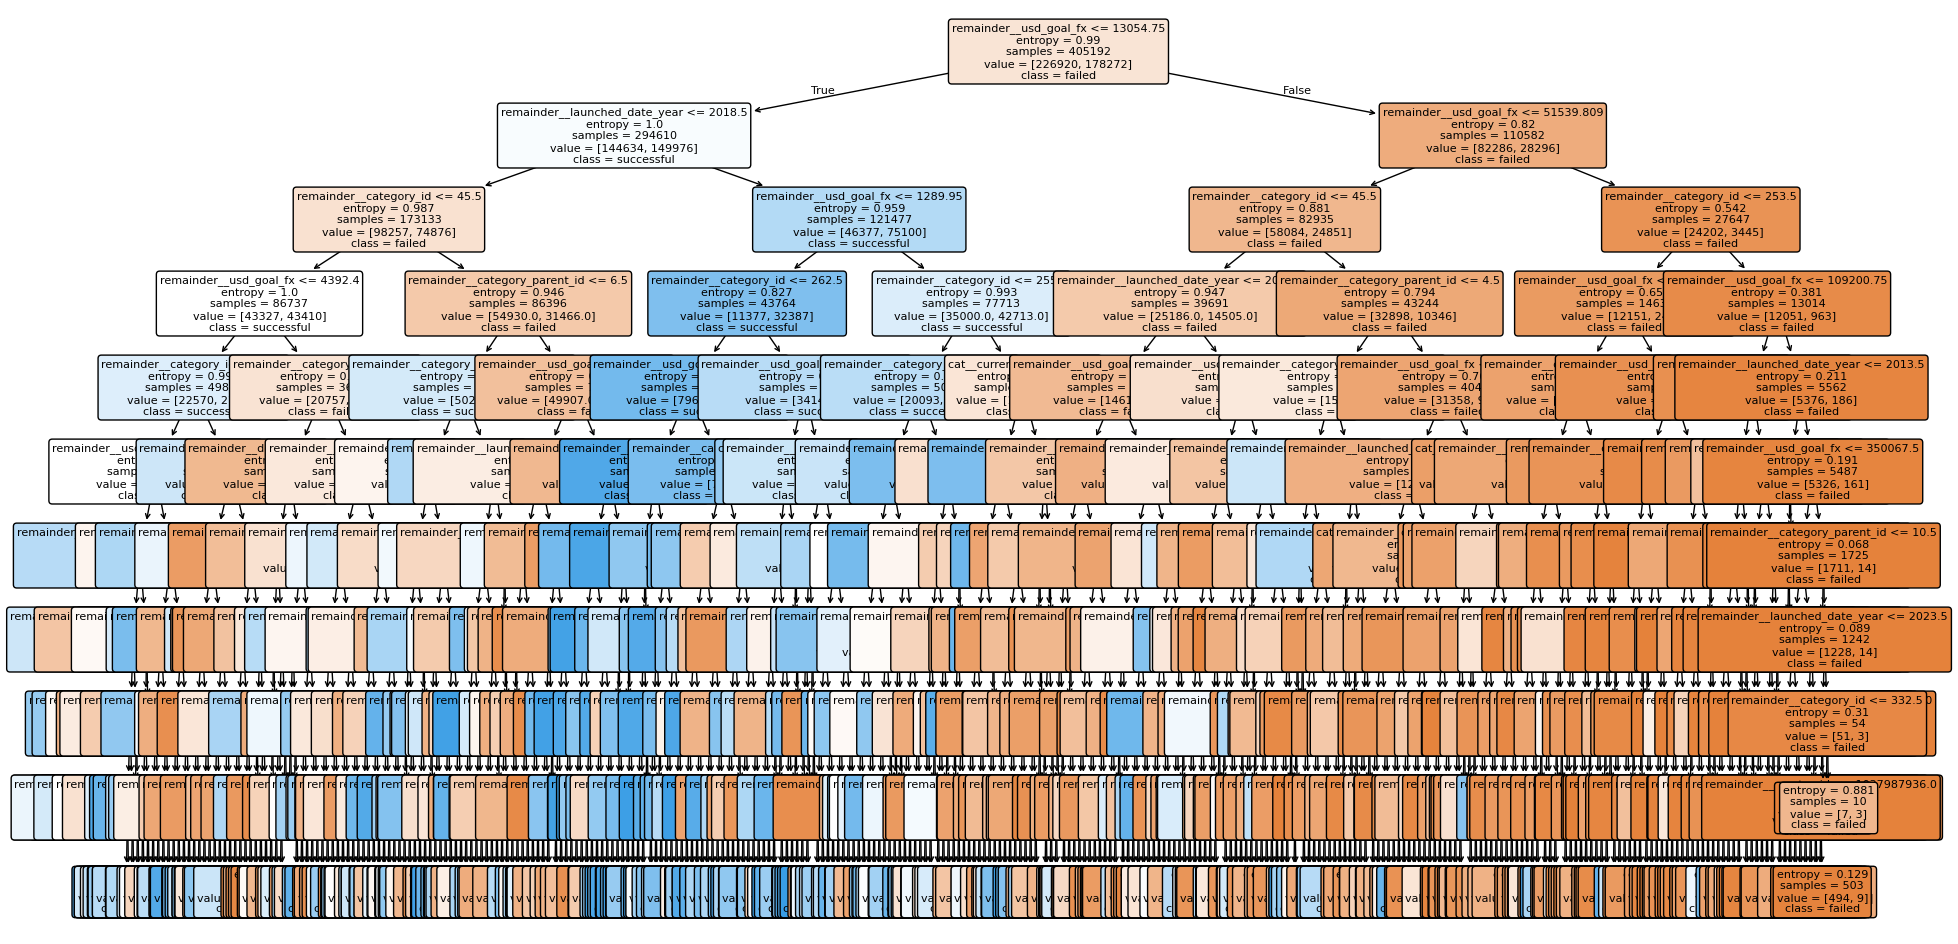

In [31]:
# koulutettu puu pipeline:sta
tree_clf = model.named_steps["classifier"]

# featuret transformerista (OHE + passthrough)
feature_names = model.named_steps["preprocess"].get_feature_names_out()

plt.figure(figsize=(22, 12))
plot_tree(
    tree_clf,
    feature_names=feature_names,
    class_names=["failed", "successful"],
    filled=True,
    rounded=True,
    fontsize=8
)
plt.show()


In [15]:
# Extract decision tree
tree = model.named_steps["classifier"]

importances = tree.feature_importances_

# OneHotEncoderin tuottamat feature-nimet
ohe = model.named_steps["preprocess"].named_transformers_["cat"]
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

# Lopullinen lista nimistä
all_feature_names = list(ohe_feature_names) + numeric_features

feature_importance_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(feature_importance_df.head(20))


                                feature  importance
116  creator_prev_projects_success_rate    0.518787
112                         usd_goal_fx    0.257029
114               project_duration_days    0.071456
115    creator_prev_projects_successful    0.023371
84              launched_date_year_2015    0.018362
48           category_parent_name_Music    0.018175
83              launched_date_year_2014    0.015571
44         category_parent_name_Fashion    0.011334
113               creator_prev_projects    0.011198
85              launched_date_year_2016    0.009187
53         category_parent_name_Theater    0.007238
45    category_parent_name_Film & Video    0.003679
60                launched_date_month_7    0.003261
52      category_parent_name_Technology    0.002966
47           category_parent_name_Games    0.002570
43          category_parent_name_Design    0.002231
41          category_parent_name_Comics    0.001631
73                     deadline_month_8    0.001525
61          

In [ ]:
# Tallennetaan malli src/models/ kansioon

joblib.dump(model, "../src/models/baseline_decision_tree.pkl")

['../src/models/baseline_decision_tree.pkl']

# GridSearchCV

In [31]:
# Käytetään GridSearchCV päätöspuun parametrien hakuun

param_grid = {
    "classifier__max_depth": [10, 20, None],
    "classifier__min_samples_split": [2, 50],
    "classifier__min_samples_leaf": [1, 10],
    "classifier__max_features": [None, "sqrt"],
    "classifier__criterion": ["gini", "entropy"],
    "classifier__class_weight": [None, "balanced"],
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2,
)

grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)

best_model = grid_search.best_estimator_

y_pred_best = best_model.predict(X_test)

print("Test accuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification report:\n", classification_report(y_test, y_pred_best))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred_best))



Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best params: {'classifier__class_weight': None, 'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_features': None, 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 50}
Best CV accuracy: 0.6870223557128696
Test accuracy: 0.6883651516294824

Classification report:
               precision    recall  f1-score   support

           0       0.69      0.77      0.73     65188
           1       0.68      0.59      0.63     54083

    accuracy                           0.69    119271
   macro avg       0.69      0.68      0.68    119271
weighted avg       0.69      0.69      0.69    119271


Confusion matrix:
 [[50346 14842]
 [22327 31756]]


# RandomForest

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,      # useampi puu -> parempi
    max_depth=None,        # antaa metsän päättää
    min_samples_split=10,  # estää ylisovitusta
    min_samples_leaf=2,
    n_jobs=-1,             # kaikki ytimet käyttöön
    random_state=42,
    max_features="sqrt"
)

model_rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("classifier", rf)
])

model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification report:\n", classification_report(y_test, y_pred_rf))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred_rf))


Accuracy: 0.7137862514777272

Classification report:
               precision    recall  f1-score   support

           0       0.72      0.79      0.75     65188
           1       0.71      0.62      0.66     54083

    accuracy                           0.71    119271
   macro avg       0.71      0.71      0.71    119271
weighted avg       0.71      0.71      0.71    119271


Confusion matrix:
 [[51566 13622]
 [20515 33568]]


In [38]:
from sklearn.model_selection import RandomizedSearchCV  # tai GridSearchCV

base_rf = RandomForestClassifier(
    n_estimators=50,     # pienempi arvo haulle
    n_jobs=-1,
    random_state=42,
)

param_distributions = {
    "max_depth": [None, 10, 15, 20],
    "min_samples_split": [2, 10, 50, 100],
    "min_samples_leaf": [1, 5, 10, 20],
    "max_features": ["sqrt", "log2", 0.3, 0.5],
    "class_weight": [None, "balanced"],
}

search = RandomizedSearchCV(
    estimator=base_rf,
    param_distributions=param_distributions,
    n_iter=20,        # paljon nopeampi kuin täysi grid
    cv=3,
    n_jobs=-1,
    verbose=1,
    scoring="accuracy",     # tai mikä sulla on
)

search.fit(X_train, y_train)

best_params = search.best_params_
print(best_params)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


ValueError: 
All the 60 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\nkyll\code\projekti2\catgpt\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\nkyll\code\projekti2\catgpt\.venv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\nkyll\code\projekti2\catgpt\.venv\Lib\site-packages\sklearn\ensemble\_forest.py", line 359, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "c:\Users\nkyll\code\projekti2\catgpt\.venv\Lib\site-packages\sklearn\utils\validation.py", line 2971, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\nkyll\code\projekti2\catgpt\.venv\Lib\site-packages\sklearn\utils\validation.py", line 1368, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "c:\Users\nkyll\code\projekti2\catgpt\.venv\Lib\site-packages\sklearn\utils\validation.py", line 1053, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\nkyll\code\projekti2\catgpt\.venv\Lib\site-packages\sklearn\utils\_array_api.py", line 757, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\nkyll\code\projekti2\catgpt\.venv\Lib\site-packages\pandas\core\generic.py", line 2171, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'US'

--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\nkyll\code\projekti2\catgpt\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\nkyll\code\projekti2\catgpt\.venv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\nkyll\code\projekti2\catgpt\.venv\Lib\site-packages\sklearn\ensemble\_forest.py", line 359, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "c:\Users\nkyll\code\projekti2\catgpt\.venv\Lib\site-packages\sklearn\utils\validation.py", line 2971, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\nkyll\code\projekti2\catgpt\.venv\Lib\site-packages\sklearn\utils\validation.py", line 1368, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "c:\Users\nkyll\code\projekti2\catgpt\.venv\Lib\site-packages\sklearn\utils\validation.py", line 1053, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\nkyll\code\projekti2\catgpt\.venv\Lib\site-packages\sklearn\utils\_array_api.py", line 757, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\nkyll\code\projekti2\catgpt\.venv\Lib\site-packages\pandas\core\generic.py", line 2171, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'GB'


In [ ]:
final_params = best_params.copy()
final_params["n_estimators"] = 300  # tai 500 jos jaksaa

final_rf = RandomForestClassifier(
    **final_params,
    n_jobs=-1,
    random_state=42,
)

final_rf.fit(X_train, y_train)


In [11]:
from utils.data_preparation import prepare_data

df = pd.read_csv("../data/feature_processed_data.csv")

num_cols = ["usd_goal_fx_log", "creator_prev_projects", "project_duration_days", "creator_prev_projects_successful"]
cat_cols = ["country", "currency", "category_parent_name", "category_name_reduced"]

X_train, X_test, y_train, y_test = prepare_data(df, num_cols, cat_cols)

preprocess_tree = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# Full decision tree pipeline
tree_clf = Pipeline(
    steps=[
        ("preprocess", preprocess_tree),
        ("model", DecisionTreeClassifier(
            max_depth=10,
            min_samples_split=50,
            min_samples_leaf=10,
            max_features=None,
            criterion="entropy",
            class_weight=None,
            random_state=42,
        )),
    ]
)

# Train model
tree_clf.fit(X_train, y_train)

# Predict
y_pred = tree_clf.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7079141946119902

Classification report:
              precision    recall  f1-score   support

           0       0.70      0.85      0.77     56772
           1       0.74      0.52      0.61     44527

    accuracy                           0.71    101299
   macro avg       0.72      0.69      0.69    101299
weighted avg       0.71      0.71      0.70    101299



In [16]:

rf_clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            min_samples_split=50,
            min_samples_leaf=10,
            max_features="sqrt",
            n_jobs=-1,
            random_state=42,
        )),
    ]
)

rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print("RandomForest accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

RandomForest accuracy: 0.7290101580469699
              precision    recall  f1-score   support

           0       0.73      0.83      0.77     56772
           1       0.73      0.60      0.66     44527

    accuracy                           0.73    101299
   macro avg       0.73      0.72      0.72    101299
weighted avg       0.73      0.73      0.72    101299



In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

preprocess_logreg = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

logreg_clf = Pipeline(
    steps=[
        ("preprocess", preprocess_logreg),
        ("model", LogisticRegression(
            max_iter=2000,
            n_jobs=-1,
        )),
    ]
)

logreg_clf.fit(X_train, y_train)
y_pred_lr = logreg_clf.predict(X_test)

print("LogReg accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

LogReg accuracy: 0.7116654656018322
              precision    recall  f1-score   support

           0       0.72      0.80      0.76     56772
           1       0.70      0.59      0.64     44527

    accuracy                           0.71    101299
   macro avg       0.71      0.70      0.70    101299
weighted avg       0.71      0.71      0.71    101299



In [14]:
from utils.data_preparation import prepare_data
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# --- PREPROCESSOR: puumalleille ym. ---
preprocess_treeish = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# --- PREPROCESSOR: lineaariset / k-NN (skaalaus numerisille) ---
preprocess_scaled = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

models = {
    # jo tuttu päätöspuu
    "DecisionTree": (
        preprocess_treeish,
        DecisionTreeClassifier(
            max_depth=10,
            min_samples_split=50,
            min_samples_leaf=10,
            criterion="entropy",
            random_state=42,
        ),
    ),

    # random forest
    "RandomForest": (
        preprocess_treeish,
        RandomForestClassifier(
            n_estimators=200,
            max_depth=None,
            min_samples_split=50,
            min_samples_leaf=10,
            max_features="sqrt",
            n_jobs=-1,
            random_state=42,
        ),
    ),

    # gradient boosting (perus, toimii yllättävän hyvin)
    "GradientBoosting": (
        preprocess_treeish,
        GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=3,
            random_state=42,
        ),
    ),

    # ExtraTrees (toinen “metsämalli”, nopea & usein hyvä)
    "ExtraTrees": (
        preprocess_treeish,
        ExtraTreesClassifier(
            n_estimators=200,
            max_depth=None,
            min_samples_split=50,
            min_samples_leaf=10,
            max_features="sqrt",
            n_jobs=-1,
            random_state=42,
        ),
    ),

    # logistinen regressio (lineaarinen baseline)
    "LogisticRegression": (
        preprocess_scaled,
        LogisticRegression(
            max_iter=2000,
            n_jobs=-1,
        ),
    ),

    # k-NN (ei todennäköisesti voita muita, mutta nopea testi)
    "KNN_10": (
        preprocess_scaled,
        KNeighborsClassifier(
            n_neighbors=10,
            n_jobs=-1,
        ),
    ),

    # LinearSVC + kalibrointi (SVM, tarvittaessa)
    "LinearSVC": (
        preprocess_scaled,
        CalibratedClassifierCV(
            estimator=LinearSVC(
                C=1.0,
                random_state=42,
            ),
            cv=3,
        ),
    ),
}

for name, (preprocess, model) in models.items():
    pipe = Pipeline(
        steps=[
            ("preprocess", preprocess),
            ("model", model),
        ]
    )

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))


=== DecisionTree ===
Accuracy: 0.7079141946119902
              precision    recall  f1-score   support

           0       0.70      0.85      0.77     56772
           1       0.74      0.52      0.61     44527

    accuracy                           0.71    101299
   macro avg       0.72      0.69      0.69    101299
weighted avg       0.71      0.71      0.70    101299


=== RandomForest ===
Accuracy: 0.7293754133801913
              precision    recall  f1-score   support

           0       0.73      0.83      0.77     56772
           1       0.73      0.60      0.66     44527

    accuracy                           0.73    101299
   macro avg       0.73      0.72      0.72    101299
weighted avg       0.73      0.73      0.73    101299


=== GradientBoosting ===
Accuracy: 0.7263447812910295
              precision    recall  f1-score   support

           0       0.72      0.84      0.77     56772
           1       0.74      0.59      0.65     44527

    accuracy             